In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use('../notebooks/style.mpl')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.colors as colors
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
import matplotlib as mpl

# Models

## Heterotrophy

Set of metabolites are:
<ul>
    <li> Corg
    <li> NAD
    <li> NADH
    <li> O2
    <li> ATP
    <li> ADP
    <li> CO2
    <li> biomass
</ul>

Set of parameters are:

<ul>
    <li> $\nu_{supply}$
    <li> $\gamma$'s
    <li> $\phi$'s
    <li> total ATP/ADP and NADH/NAD+ pools
</ul>

In [70]:
eps = 1e-10
tau = 1e-1

In [71]:
S2 = 2.

In [72]:
def het_model( t, y ):
    x = y.copy()
    x[x<eps] = 0.0
    x[x>1e8] = 1e8
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]
    
    NAD = r1 * NADH
    ADP = r2 * ATP
    
    nu_cat = (NAD ** S2) * phi_cat * gamma_cat_inv * tau
    nu_resp = (NADH ** 2) * phi_resp * gamma_resp_inv * tau
    nu_ana = (NADH ** S6) * (ATP ** S5) * phi_ana * gamma_ana_inv * tau
    
    mu = nu_ana.copy()
    
    # dCorg = - nu_cat - nu_ana + nu_supply - mu * Corg
    dCorg = 0.0
    # dNADH = S2 * nu_cat - 2 * nu_resp - S6 * nu_ana - mu * NADH
    dNADH = 0.0
    dNAD = - dNADH
    dO2 = 0.0
    dATP = (S3 * nu_cat + S4 * nu_resp - S5 * nu_ana - mu * ATP)
    dADP = -dATP
    
    dydt = np.array([dCorg, dNADH, dO2, dATP])
    return dydt

# Simulations

## Parameters

In [73]:
# gammas are in (g s)/(mol) units.
gamma_cat_inv = 1000/3600
gamma_resp_inv = 1000/3600
gamma_ana_inv = 1000/3600

phi_cat = 0.5
phi_ana = 0.4
phi_resp = 0.1

# Default params: reliance on respiration.
S4 = 4.0    # ATP yield of respiration
S3 = 0.3    # ATP yield of catabolism ... NOTE: default should be 0.5
S5 = 1.1    # ATP cost of anabolism
S6 = 0.2    # reduction coefficient of biomass

### Initial conditions

In [74]:
# micromolar concentrations
Corg0 = 1e1
NADH0 = 1e1
O20 = 1e1
ATP0 = 1e1

# KM is in uM
KM = 100
r1 = 10.
r2 = 0.1

### Dynamics

In [75]:
y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
NUM_METS = len(y0)

# Evaluation time
TFINAL = 1e6
t = np.logspace(-4, 2, 1000 )
S6 = 0.1

### Fluxes

In [76]:
def give_nus( y_sol, tpt ):
    x = y_sol[:, tpt].copy()
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]

    NAD = r1 * NADH
    ADP = r2 * ATP

    nu_cat = (NAD ** 2) * phi_cat * gamma_cat_inv * tau
    nu_resp = (NADH ** 2) * phi_resp * gamma_resp_inv * tau
    nu_ana = (NADH ** S6) * (ATP ** S5) * phi_ana * gamma_ana_inv * tau
    
    return np.array([nu_cat, nu_resp, nu_ana])

In [77]:
y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

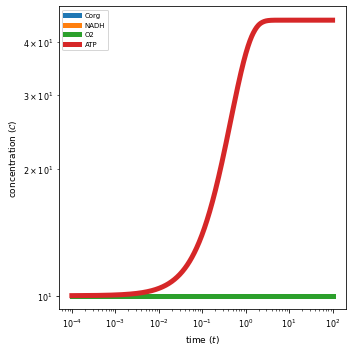

In [78]:
fig, ax = plt.subplots( 1, 1, figsize=(5, 5) )

ax.set_ylabel( 'concentration (' + r'$\mathcal{C}$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(NUM_METS):
    ax.plot( t[:len(y_sol[idx])], y_sol[idx], lw=5 )
ax.legend([ 'Corg', 'NADH', 'O2', 'ATP' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

In [79]:
nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

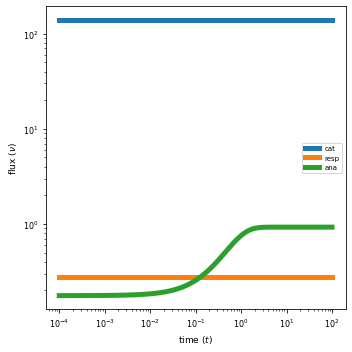

In [80]:
fig, ax = plt.subplots( 1, 1, figsize=(5, 5) )

ax.set_ylabel( 'flux (' + r'$\nu$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(3):
    ax.plot( t[:len(nus[idx])], nus[idx], lw=5 )
ax.legend([ 'cat', 'resp', 'ana' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

# Calculating NADH stoichiometries from $Z_C$ values.

Helper functions below calculate NADH stoichiometry from redox properties of biomass, substrates and products. How do we do this? 

Glucose has $Z_C = 0$ and $N_C = 6$. CO$_2$ has $Z_C=+4$. The number of electrons released converting one glucose to 6 CO$_2$ is $= 4*6 - 0*6 = 24$. Since 1 NADH caarries 2 electrons, we see that complete oxidation of glucose to CO2 produces 12 NADH, or 2 NADH per glucose carbon. This is the value of $S_2$, the number of NADH produced per C during catabolism. 

In contrast to glucose, succinate has $Z_C = +1/2$ and $N_C = 4$. If succinate is converted to CO$_2$ then $4*4 - 0.5*4 = 14$, meaning that 7 NADH are produced in this catabolism, or $7/4 = 1.75$ NADH/C. 

Now let's consider biomass production from glucose. Suppose biomass is slightly more reduced than glucose, with $Z_C = -0.4$. This means each C atom in biomass requires $(0-0.4)/2 = 0.2$ NADH molecules for its synthesis. This is the value of $S_6$ -- the NADH usage per C in anabolism. 

In [81]:
# Helper functions

def _calc_S2(ZC_org, ZC_prod):
    """Returns the per-C NADH yield of catabolism.
    
    Args:
        ZC_org (float): the average oxidation state of C in the organic substrate.
        ZC_prod (float): the average oxidation state of C in the product.
    """
    return (ZC_prod - ZC_org)/2

def _calc_S6(ZC_org, ZC_bm):
    """Returns the per-C NADH usage of anabolism, S6.
    
    Args:
        ZC_org (float): the average oxidation state of C in the organic substrate.
        ZC_bm (float): the average oxidation state of C in biomass.
    """
    return (ZC_org - ZC_bm)/2

# Avi: Not positive I understand these defaults... Discuss with Akshit. 
DEFAULT_S3 = 0.3  # ATP prod per C in catabolism
DEFAULT_S4 = 4.0  # ATP prod per C in respiration
DEFAULT_S5 = 1.1  # ATP cons per C in anabolism
# Something unintuitive happens here: lowering S5 reduces the max growth rate?

def _default_stoichs(ZC_org, ZC_prod, ZC_bm):
    """Returns default values for stoichiometric coefficients.
    
    Returns:
        A tuple of floats (S2, S3, S4, S5, S6).
            S2 (float): per-C NADH yield of catabolism.
            S3 (float): ATP per C in catabolism.
            S4 (float): ATP per C in respiration.
            S5 (float): ATP per C in anabolism.
            S6 (float): per-C NADH usage of anabolism.
    """
    return (
        _calc_S2(ZC_org, ZC_prod),
        DEFAULT_S3, DEFAULT_S4, DEFAULT_S5,
        _calc_S6(ZC_org, ZC_bm))

DEFAULT_gamma_inv = 1000/3600

def _default_gamma_inv():
    """Returns default values for gamma_inv.

    Returns:
        A tuple of floats (gamma_cat_inv, gamma_resp_inv, gamma_ana_inv).
    """
    return (DEFAULT_gamma_inv, DEFAULT_gamma_inv, DEFAULT_gamma_inv)

# Performing simulations

The simulations here are running with chosen parameters for the figure. A detailed parameter scan with the full range of simulations is done elsewhere.

In [109]:
# ZC values are per C atom.
ZC_org = 0.0
NC_org = 6.0
ZC_co2 = 4.0
# FBA estimates biomass a bit more reduced than glucose. 
ZC_bm = -0.4

##############################################
## Fig. 1B simulation
##############################################
allmus, allphianas = [], []
tau = 1e-1

# Default stoichiometric coefficients
S2, S3, S4, S5, S6 = _default_stoichs(ZC_org, ZC_co2, ZC_bm)

# Default gamma_inv values
gamma_cat_inv, gamma_resp_inv, gamma_ana_inv = _default_gamma_inv()

# everything in units of KM
Corg0 = 1e1
NADH0 = 1e1
O20 = 1e1
ATP0 = 1e1

print('Fig 1B simulation')
print('S2 = {}, S3 = {}, S4 = {}, S5 = {}, S6 = {}'.format(S2, S3, S4, S5, S6))
print('1/gamma_ana = {}, 1/gamma_cat = {}, 1/gamma_resp = {}'.format(gamma_ana_inv, gamma_cat_inv, gamma_resp_inv))

for indx, t_phi_o in enumerate(np.linspace(0.4, 0.6, 3)):
    mus = []
    phianas = []
    phi_o = t_phi_o
    phi_resp = 0.05

    for t_phi_ana in np.linspace(0.00, 1-phi_o-phi_resp, 200):
        phi_cat = 1-phi_o-phi_resp-t_phi_ana
        phi_ana = t_phi_ana.copy()

        y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
        NUM_METS = len(y0)

        # Evaluation time
        TFINAL = 1e6
        t = np.logspace(-4, 6, 1000 )
        S6 = 0.7

        y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y


        nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

        mus.append(nus[-1, -1])
        phianas.append(t_phi_ana)

    mus.append(0.0)
    phianas.append(t_phi_ana)
    allmus.append(mus)
    allphianas.append(phianas)

df_1b = pd.DataFrame({'mus': allmus, 'phianas': allphianas})

##############################################
## Fig. 1C simulation -- varying Jresp
##############################################
allmus, allnuresps, allphiresps = [], [], []
tau = 6e-2

# Reset to default stoichiometric coefficients.
S2, S3, S4, S5, S6 = _default_stoichs(ZC_org, ZC_co2, ZC_bm)

# Lower gamma (higher gamma_inv) values to keep max growth rate in range
gamma_cat_inv, gamma_resp_inv, gamma_ana_inv = _default_gamma_inv()

# To get a more peaked curve, we need make a larger disparity between
# respiratory and catabolic ATP yield
S4 = 20.0  # ATP yield of respiration
S3 = 0.1   # ATP yield of catabolism
S5 = 3     # ATP cost of anabolism

# everything in units of KM
Corg0 = 1e1
NADH0 = 1e1
O20 = 1e1
ATP0 = 1e1

phi_o = 0.4
phi_cat = 0.3

print('Fig 1C simulation -- varying Jresp')
print('S2 = {}, S3 = {}, S4 = {}, S5 = {}, S6 = {}'.format(S2, S3, S4, S5, S6))
print('1/gamma_ana = {}, 1/gamma_cat = {}, 1/gamma_resp = {}'.format(gamma_ana_inv, gamma_cat_inv, gamma_resp_inv))

for indx, t_phi_o in enumerate(np.linspace(0.4, 0.6, 3)):
    phi_o = t_phi_o.copy()
    if indx == 1:
        phi_cat = 0.28
    elif indx == 2:
        phi_cat = 0.25
    mus, phianas, phiresps, allatps, nuresps = [], [], [], [], []
    for t_phi_resp in np.linspace(0.00, 1-phi_o-phi_cat, 200):
        phi_resp = t_phi_resp.copy()
        phi_ana = 1-phi_o-phi_cat-phi_resp

        y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
        NUM_METS = len(y0)

        # Evaluation time
        TFINAL = 1e6
        t = np.logspace(-4, 6, 1000 )
        S6 = 0.1

        y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y


        nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

        mus.append(nus[-1, -1])
        phiresps.append(phi_resp)
        nuresps.append((y_sol[1, -1] ** 2) * phi_resp * gamma_resp_inv * tau)
        allatps.append(y_sol[3, -1])

    allnuresps.append(nuresps)
    allmus.append(mus)
    allphiresps.append(phiresps)

df_1c = pd.DataFrame({'mus': allmus, 'nuresps': allnuresps, 'phiresps': allphiresps})

##############################################
## Fig. 1D simulation -- varying ZC_org
##############################################
allmus, allphianas, all_zc_orgs = [], [], []

# Reset default stoichiometric coefficients
S2, S3, S4, S5, S6 = _default_stoichs(ZC_org, ZC_co2, ZC_bm)

# Default gamma_inv values
gamma_cat_inv, gamma_resp_inv, gamma_ana_inv = _default_gamma_inv()

# Set the cost of respiration (gamma_resp) higher to accentuate
# the effect of changing NADH production/consumption of catabolism and anabolism
# via alterations of the ZC_org value.
gamma_resp_inv = 200/3600

tau = 1e-1
phi_o = 0.4

print('Fig 1C simulation -- varying ZC_org')
print('S2 = {}, S3 = {}, S4 = {}, S5 = {}, S6 = {}'.format(S2, S3, S4, S5, S6))
print('1/gamma_ana = {}, 1/gamma_cat = {}, 1/gamma_resp = {}'.format(gamma_ana_inv, gamma_cat_inv, gamma_resp_inv))

for indx, new_ZC_org in enumerate([-1, 0, 1]):
    mus = []
    phianas = []
    phi_resp = 0.1

    for t_phi_ana in np.linspace(0.00, 1-phi_o-phi_resp, 200):
        phi_cat = 1-phi_o-phi_resp-t_phi_ana
        phi_ana = t_phi_ana.copy()

        y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
        NUM_METS = len(y0)

        # Evaluation time
        TFINAL = 1e6
        t = np.logspace(-4, 6, 1000 )

        # This calculation accounts for the interdependence between S2 and S6.
        S2, S3, S4, S5, S6 = _default_stoichs(new_ZC_org, ZC_co2, ZC_bm)

        y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

        nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

        mus.append(nus[-1, -1])
        phianas.append(t_phi_ana)

    mus.append(0.0)
    phianas.append(t_phi_ana)
    allmus.append(mus)
    allphianas.append(phianas)
    all_zc_orgs.append(new_ZC_org)

df_1d = pd.DataFrame({'mus': allmus, 'phianas': allphianas, 'ZC_orgs': all_zc_orgs})

##############################################
## Fig. 1E
##############################################
all_mus = []
all_zcs = []

# Reset default stoichiometric coefficients
S2, S3, S4, S5, S6 = _default_stoichs(ZC_org, ZC_co2, ZC_bm)
gamma_cat_inv, gamma_resp_inv, gamma_ana_inv = _default_gamma_inv()

# Default params: reliance on respiration.
NADH0 = 10. # init NADH conc in units of KM

for indx in range(3):
    mus = []
    zcs = []
    tau = 1e-1
    phi_o = 0.4
    phi_cat = 0.2
    phi_resp = 0.1

    if indx == 1:
        NADH0 = 6.0
    elif indx == 2:
        NADH0 = 14.
        S4 = 20.

    phi_ana = 1 - phi_cat - phi_resp - phi_o

    for S6 in np.linspace(-0.1, 0.5, 100):
        y0 = np.array([Corg0, NADH0, O20, ATP0])
        NUM_METS = len(y0)

        # Evaluation time
        TFINAL = 1e6
        t = np.logspace(-4, 6, 1000)

        y_sol = solve_ivp(het_model, [1e-4, TFINAL], y0, t_eval=t, method='Radau').y

        nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

        mus.append(nus[-1, -1])
        zcs.append(S6)

    all_mus.append(mus)
    all_zcs.append(zcs)

df_1e = pd.DataFrame({'mus': all_mus, 'zcs': all_zcs})


Fig 1B simulation
S2 = 2.0, S3 = 0.3, S4 = 4.0, S5 = 1.1, S6 = 0.2
1/gamma_ana = 0.2777777777777778, 1/gamma_cat = 0.2777777777777778, 1/gamma_resp = 0.2777777777777778
Fig 1C simulation -- varying Jresp
S2 = 2.0, S3 = 0.1, S4 = 20.0, S5 = 3, S6 = 0.2
1/gamma_ana = 0.2777777777777778, 1/gamma_cat = 0.2777777777777778, 1/gamma_resp = 0.2777777777777778
Fig 1C simulation -- varying ZC_org
S2 = 2.0, S3 = 0.3, S4 = 4.0, S5 = 1.1, S6 = 0.2
1/gamma_ana = 0.2777777777777778, 1/gamma_cat = 0.2777777777777778, 1/gamma_resp = 0.05555555555555555


# Plotting Fig. 1

[0.0, 0.002512562814070352, 0.005025125628140704, 0.007537688442211055, 0.010050251256281407, 0.01256281407035176, 0.01507537688442211, 0.017587939698492462, 0.020100502512562814, 0.022613065326633167, 0.02512562814070352, 0.02763819095477387, 0.03015075376884422, 0.032663316582914576, 0.035175879396984924, 0.03768844221105528, 0.04020100502512563, 0.04271356783919598, 0.04522613065326633, 0.04773869346733668, 0.05025125628140704, 0.052763819095477386, 0.05527638190954774, 0.05778894472361809, 0.06030150753768844, 0.06281407035175879, 0.06532663316582915, 0.0678391959798995, 0.07035175879396985, 0.0728643216080402, 0.07537688442211056, 0.07788944723618091, 0.08040201005025126, 0.0829145728643216, 0.08542713567839195, 0.08793969849246232, 0.09045226130653267, 0.09296482412060302, 0.09547738693467336, 0.09798994974874373, 0.10050251256281408, 0.10301507537688442, 0.10552763819095477, 0.10804020100502512, 0.11055276381909548, 0.11306532663316583, 0.11557788944723618, 0.11809045226130653, 

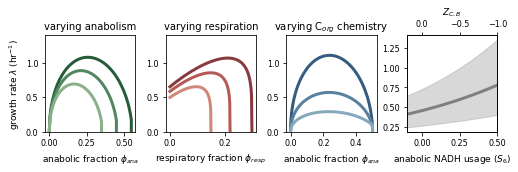

In [111]:
# Create the figure
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(7.24, 2.5))

##############################################
## Fig. 1B
##############################################
plt.sca(axs[0])
plt.ylabel('growth rate ' + r'$\lambda$' + ' (hr$^{-1}$)')
plt.xlabel('anabolic fraction ' + r'$\phi_{ana}$')

cs = sns.color_palette('Greens_r', 5, desat=0.5)
legend_elements = []

phi_os=np.linspace(0.4, 0.6, 3)
for indx in range(len(df_1b)):
    phianas = df_1b.iloc[indx]['phianas']
    mus = df_1b.iloc[indx]['mus']
    plt.plot( phianas, mus, lw=3, c=cs[indx] )
    legend_elements.append(r'$\phi_o = $' + str(phi_os[indx]))
plt.legend(legend_elements, loc=4, fontsize=6.5).set_visible(False)

##############################################
## Fig. 1C
##############################################
plt.sca(axs[1])
plt.ylabel( '')
plt.xlabel( 'respiratory fraction ' + r'$\phi_{resp}$' )

cs = sns.color_palette('Reds_r', 5, desat=0.5)
legend_elements = []

for indx in range(len(df_1c)):
    nuresps = df_1c.iloc[indx]['nuresps']
    phiresps = df_1c.iloc[indx]['phiresps']
    mus = df_1c.iloc[indx]['mus']
    # plt.plot( nuresps, mus, lw=3, c=cs[indx] )
    plt.plot( phiresps, mus, lw=3, c=cs[indx] )
    legend_elements.append(r'$\phi_o = $' + str(phi_os[indx]))

plt.legend(legend_elements, loc='best').set_visible(False)

##############################################
## Fig. 1D
##############################################
plt.sca(axs[2])
plt.ylabel( '')
plt.xlabel( 'anabolic fraction ' + r'$\phi_{ana}$' )

cs = sns.color_palette('Blues_r', 5, desat=0.5)
legend_elements = []

for indx, my_ZC_org in enumerate(sorted(df_1d.ZC_orgs.unique())):
    mask = df_1d['ZC_orgs'] == my_ZC_org
    phianas = df_1d[mask].iloc[0]['phianas']
    print(phianas)
    mus = df_1d[mask].iloc[0]['mus']
    plt.plot( phianas, mus, lw=3, c=cs[indx] )
    legend_elements.append(r'$Z_C^{{org}} = $ {0:.1f}'.format(my_ZC_org))

plt.legend(legend_elements, loc='best', fontsize=6.5).set_visible(False)

##############################################
## Fig. 1E
##############################################
plt.sca(axs[3])
plt.ylabel('')
plt.xlabel('anabolic NADH usage (' + r'$S_6$' + ')')

all_mus = df_1e['mus']
all_zcs = df_1e['zcs']

for indx in range(3):
    S6s = all_zcs[indx]
    mus = all_mus[indx]
    if indx == 1 or indx == 2:
        plt.plot(S6s, mus, lw=0, c='grey')
    else:
        plt.plot(S6s, mus, lw=3, c='grey')

# Filling the gap between the second and third curves
if len(all_mus) >= 3:
    plt.fill_between(all_zcs[1], all_mus[1], all_mus[2], alpha=0.3, color='grey')
# need to define the x-axis limits that map directly to the ZC values.
plt.xlim(np.min(S6s), np.max(S6s))
plt.xticks(np.arange(0, 0.51, 0.25))

# Add parallel x-axis
# ticks, labels = axs[3].get_xticks()
ax2 = plt.twiny()
# In this plot we assume the C-source is glucose which has ZC=0.
# Hence ZC = -2*S6, where S6 is anabolic stoichiomtery of NADH when using
# glucose as the effective substrat. 
zcs = -np.array(S6s) * 2
ax2.plot(zcs, mus, lw=0, c=cs[indx])
# Need to invert the x-axis so that the direction matches the main x-axis.
ax2.set_xlim(zcs.max(), zcs.min())
plt.xlabel(r'$Z_{C,B}$')

# Ticks for panels B-D
gr_yticks = np.arange(0, 1.1, 0.5)
titles = 'varying anabolism,varying respiration,varying C$_{org}$ chemistry'.split(',')
for ax, t in zip(axs[:-1], titles):
    plt.sca(ax)
    plt.yticks(gr_yticks)
    plt.ylim(0.0, 1.4)
    plt.title(t)

plt.tight_layout()
plt.savefig('../output/Fig1.png', facecolor='w', dpi=300)
plt.show()

In [112]:
# Calculate a confidence interval for the slope of he mu/ZC curve.
slope_u_s6 = (all_mus[0][-1] - all_mus[0][0])/(all_zcs[0][-1] - all_zcs[0][0])
slope_u_ZC = slope_u_s6 / 2
print('mu/ZC slope = {0:.2f}'.format(slope_u_ZC))

mu/ZC slope = 0.31
